In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import getcwd
os.chdir('/Users/maneetsingh/Documents/University of Chicago/Financial Mathematics/4. Spring Quarter/Time Series/ts_forex_project')

### Data Pre-Processing

In [19]:
# Read Data from CSV
forex_data = pd.read_csv(getcwd() + '/data/Foreign_Exchange_Rates.csv', na_values='ND')

#Column Cleanup
extracted_columns = ['Time Serie', 'EURO AREA - EURO/US$', 'NEW ZEALAND - NEW ZELAND DOLLAR/US$', 'UNITED KINGDOM - UNITED KINGDOM POUND/US$', 'CANADA - CANADIAN DOLLAR/US$', 'JAPAN - YEN/US$']
named_columns = ['date', 'EURUSD', 'NZDUSD', 'GBPUSD', 'CADUSD', 'JPYUSD']
forex_data = forex_data[extracted_columns]
forex_data.columns = named_columns

# Set Date as Index
forex_data = forex_data.set_index('date')
forex_data.index = pd.to_datetime(forex_data.index) 

#Keep Only Business Days
forex_data = forex_data.dropna()

#Display Sample
display(forex_data.head())

,EURUSD,NZDUSD,GBPUSD,CADUSD,JPYUSD
date,,,,,
2000-01-03,0.9847,1.9033,0.6146,1.4465,101.70
2000-01-04,0.9700,1.9238,0.6109,1.4518,103.09
2000-01-05,0.9676,1.9339,0.6092,1.4518,103.77
2000-01-06,0.9686,1.9436,0.6070,1.4571,105.19
2000-01-07,0.9714,1.9380,0.6104,1.4505,105.17


### Data Summary

,EURUSD,NZDUSD,GBPUSD,CADUSD,JPYUSD
# of Non-Missing Observations,"5,019.00","5,019.00","5,019.00","5,019.00","5,019.00"
Mean,0.84,1.54,0.64,1.23,106.59
Median,0.82,1.44,0.64,1.24,109.02
Minimum Value,0.62,1.13,0.47,0.92,75.72
Maximum Value,1.21,2.55,0.83,1.61,134.77


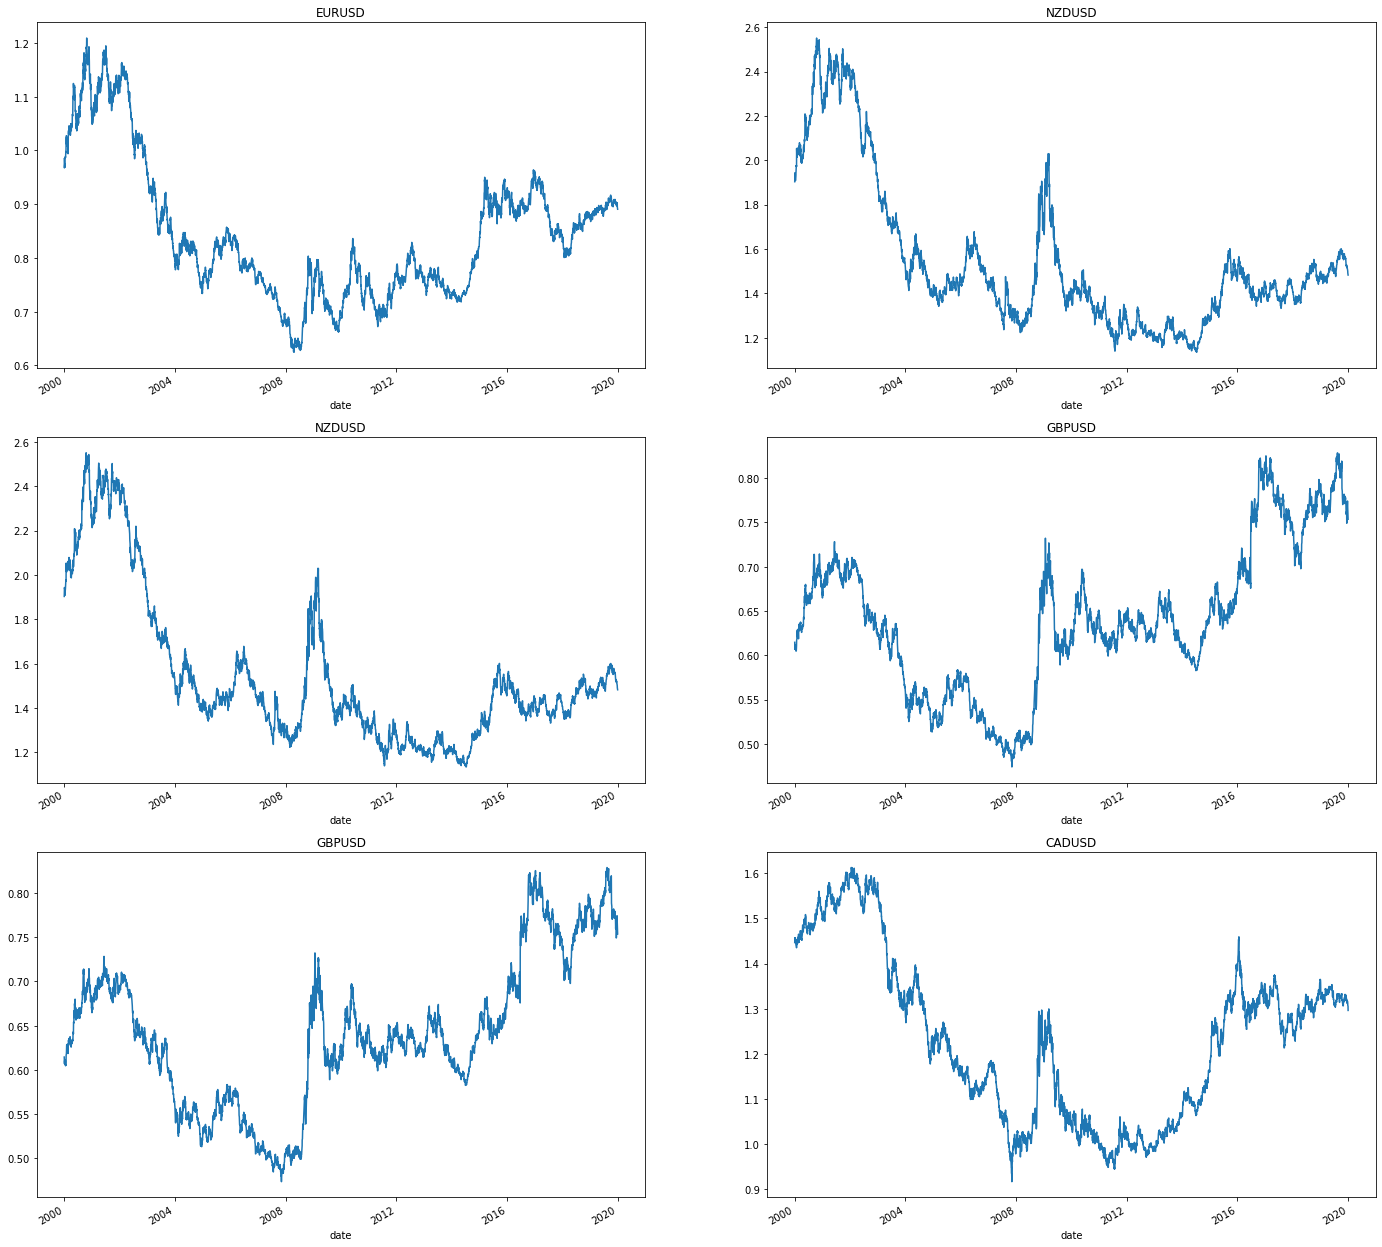

In [44]:
pa_summary = forex_data.describe()
pa_summary = pa_summary.loc[['count', 'mean', '50%', 'min', 'max']]
pa_summary.index = ['# of Non-Missing Observations', 'Mean', 'Median', 'Minimum Value', 'Maximum Value']

# Data Summary Table
display(pa_summary.style.format('{:,.2f}'))

# Data Plots
rows = 3
cols = 2
fig, ax = plt.subplots(rows, cols, figsize = (24,24))

for i in range(rows):
    for j in range(cols):
        forex_data.iloc[:,(i+j)].plot(ax = ax[i][j])
        ax[i][j].set_title(forex_data.iloc[:,(i+j)].name)